# Train disruptions predict duration 

The first attempt seems to lead to +- 70% accuracy in determining if the duration of a disruption will be longer or short than 1.5 hours, which is only 40% better than just guessing.

In [9]:
import matplotlib

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

In [10]:
import numpy as np
import pandas as pd

In [11]:
# Details regarding the data https://www.rijdendetreinen.nl/over/open-data
dfo = pd.read_csv('disruptions-2011-2018.csv')

In [12]:
dfo.sample(5)

,rdt_id,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time,duration_minutes
23808,25075,Den Haag-Rotterdam,"Den Haag Centraal - Den Haag HS, Den Haag HS -...","10,11","Delft,Delft Zuid,Den Haag HS,Den Haag Centraal...","DT, DTZ, GV, GVC, GVMW, RSW, RTD, SDM",defecte trein,broken down train,defecte trein,broken down train,rolling stock,2018-12-17 17:31:15,2018-12-17 19:46:26,135.0
8293,9549,Utrecht-Hilversum/Amersfoort/Breukelen,NaN,NaN,NaN,NaN,herstelwerkzaamheden,repair works,herstelwerkzaamheden,repair works,engineering work,2014-11-10 19:18:01,2014-11-10 20:02:02,44.0
14907,16163,Almelo-Hardenberg,Almelo - Mariënberg,96,"Almelo,Daarlerveen,Vroomshoop,Vriezenveen","AML, DA, VHP, VZ",wisselstoring,points failure,wisselstoring,points failure,infrastructure,2017-01-16 18:35:19,2017-01-16 21:29:47,174.0
21579,22846,Alkmaar-Den Helder; Alkmaar-Hoorn,"Alkmaar - Den Helder, Alkmaar - Hoorn","162,163","Alkmaar,Alkmaar Noord,Heerhugowaard","AMR, AMRN, HWD",defecte spoorbrug,damaged railway bridge,defecte spoorbrug,damaged railway bridge,infrastructure,2018-07-27 15:41:42,2018-07-27 17:36:01,114.0
18035,19302,Rotterdam-Dordrecht,Dordrecht - Rotterdam Centraal,16,"Barendrecht,Dordrecht,Rotterdam Lombardijen,Ro...","BRD, DDR, RLB, RTB, RTD, RTST, RTZ, ZWD",defecte trein,broken down train,defecte trein,broken down train,rolling stock,2017-10-26 07:47:13,2017-10-26 08:29:43,43.0


First thoughts:

Maybe we could predict the duration of an event based on: location, cause, day, etc.


In [13]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23969 entries, 0 to 23968
Data columns (total 14 columns):
rdt_id                  23969 non-null int64
ns_lines                23969 non-null object
rdt_lines               22619 non-null object
rdt_lines_id            22619 non-null object
rdt_station_names       9088 non-null object
rdt_station_codes       9088 non-null object
cause_nl                23784 non-null object
cause_en                23784 non-null object
statistical_cause_nl    23784 non-null object
statistical_cause_en    23784 non-null object
cause_group             23967 non-null object
start_time              23969 non-null object
end_time                23967 non-null object
duration_minutes        23967 non-null float64
dtypes: float64(1), int64(1), object(12)
memory usage: 2.6+ MB


Hence, we need to do some data filling

In [14]:
dfo.describe()

,rdt_id,duration_minutes
count,23969.000000,23967.000000
mean,13134.207435,155.901323
std,7102.761187,671.947011
min,1.000000,0.000000
25%,7245.000000,34.000000
50%,13240.000000,83.000000
75%,19243.000000,163.000000
max,25235.000000,64927.000000


In [15]:
dfo.describe(include='O')

,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time
count,23969,22619,22619,9088,9088,23784,23784,23784,23784,23967,23969,23967
unique,2295,500,497,1139,1135,84,83,84,82,9,23935,23404
top,Rotterdam-Breda (HSL),Breda - Rotterdam Centraal (HSL),15,"Breda,Rotterdam Centraal","BD, RTD",defecte trein,broken down train,defecte trein,broken down train,infrastructure,2016-09-15 14:32:02,2011-07-02 09:52:02
freq,418,586,586,433,433,5555,5555,5603,5603,8328,2,4


Possibly add the features: day of the week and hour of the day for the start time. End time is not known when predicting.

In [16]:
print(dfo.columns.values)

['rdt_id' 'ns_lines' 'rdt_lines' 'rdt_lines_id' 'rdt_station_names'
 'rdt_station_codes' 'cause_nl' 'cause_en' 'statistical_cause_nl'
 'statistical_cause_en' 'cause_group' 'start_time' 'end_time'
 'duration_minutes']


In [105]:
# Extracting the relevant data 
df = dfo.copy(deep=True)
df = df[~df['duration_minutes'].isna()]
df = df[~df['rdt_lines'].isna()]
df = df[~df['cause_en'].isna()]

df['cause_group'] = df['cause_group'].fillna('unknown')
df['cause_group'] = df['cause_group'].fillna('unknown')

df = df.reset_index(drop=True)

y = df['duration_minutes']
y, bins = pd.cut(y, [0, 90, 1000000], labels=range(2), retbins=True)
#y, bins = pd.qcut(y, 2, labels=range(2), retbins=True)
y = y.values.astype(np.int8)

drop_cols = ['rdt_id', 
             'ns_lines', 
             'rdt_lines_id',
             'rdt_station_codes', 
             'cause_nl', 
             'statistical_cause_nl',
             'end_time', 
             'duration_minutes']

df = df.drop(columns=drop_cols)

In [106]:
print(bins)
pd.value_counts(y)

[      0      90 1000000]


0    12135
1    10452
dtype: int64

We want to engineer:
* Day of the week
* Month of the year
* Year 
* Hour of the day
* Number of affected station 
* Number of affected lines

In the future possibly expand with:
* Km of track affected 
* Estimate for the location in NL (let's say per province), or rural vs city area

In [107]:
start_time = df['start_time']
start_time = pd.to_datetime(start_time)

In [108]:
year = start_time.apply(lambda x: x.year - 2000).values.astype(np.int8)
month = start_time.apply(lambda x: x.month).values.astype(np.int8)
weekday = start_time.apply(lambda x: x.weekday()).values.astype(np.int8)
hour = start_time.apply(lambda x: x.hour).values.astype(np.int8)

In [109]:
#df['year'] = year
# df['monthSin'] = np.sin(2*np.pi*weekday/11)
# df['monthCos'] = np.cos(2*np.pi*month/11)
# df['weekdaySin'] = np.sin(2*np.pi*weekday/6)
# df['weekdayCos'] = np.cos(2*np.pi*weekday/6)
df['hourSin'] = np.sin(2*np.pi*hour/23)
df['hourCos'] = np.cos(2*np.pi*hour/23)
df = df.drop(columns=['start_time'])

In [110]:
df

,rdt_lines,rdt_station_names,cause_en,statistical_cause_en,cause_group,hourSin,hourCos
0,Amersfoort - Apeldoorn,NaN,by police orders,by police orders,external,-2.449294e-16,1.000000
1,Amersfoort - Ede-Wageningen,NaN,by police orders,by police orders,external,0.000000e+00,1.000000
2,Breda - Roosendaal,NaN,copper theft,copper theft,external,9.976688e-01,-0.068242
3,Eindhoven - Venlo,NaN,person hit by a train,person hit by a train,accidents,9.422609e-01,-0.334880
4,Leiden Centraal - Utrecht Centraal,NaN,broken down train,broken down train,rolling stock,9.422609e-01,-0.334880
...,...,...,...,...,...,...,...
22582,Haarlem - Leiden Centraal,"Heemstede-Aerdenhout,Hillegom,Haarlem,Leiden C...",broken down train,broken down train,rolling stock,6.310879e-01,-0.775711
22583,Den Haag Centraal - Leiden Centraal,"De Vink,Den Haag Centraal,Den Haag Mariahoeve,...",disruption elsewhere,disruption elsewhere,logistical,6.310879e-01,-0.775711
22584,Amsterdam Centraal - Haarlem,"Amsterdam Centraal,Amsterdam Sloterdijk,Haarle...",disruption elsewhere,disruption elsewhere,logistical,3.984011e-01,-0.917211
22585,Rotterdam Centraal - Schiphol Airport (HSL),"Rotterdam Centraal,Schiphol Airport",broken down train,broken down train,rolling stock,1.361666e-01,-0.990686


In [111]:
df = pd.concat([df, pd.get_dummies(df['cause_group'], prefix='cause')], axis=1)
df = df.drop(columns=['cause_group'])

In [112]:
df['affected_lines'] = df['rdt_lines'].apply(lambda x: len(x.split(',')))
df = df.drop(columns=['rdt_lines'])

In [113]:
a = pd.value_counts(df['statistical_cause_en']) < 50
a = dict(a)
temp = pd.get_dummies(df['statistical_cause_en'].apply(lambda x: ('other' if a[x] else x)),
                      prefix='statcause')

df = pd.concat([df, temp], axis=1)

In [114]:
df = df.drop(columns=['rdt_station_names', 'cause_en', 'statistical_cause_en'])

In [115]:
X = df

In [116]:
assert(len(X) == len(y ))

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [119]:
import seaborn as sea
import matplotlib.pyplot as plt

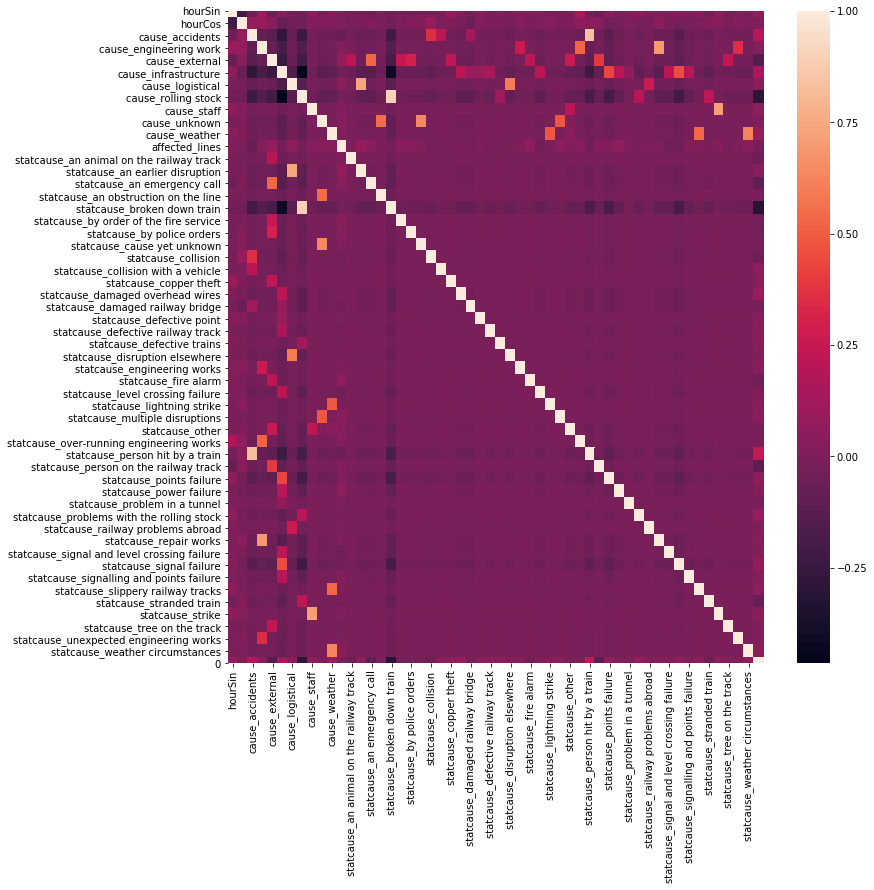

In [120]:
plt.figure(figsize=(12,12))
corr_matrix = pd.concat([X, pd.DataFrame(y)], axis=1).corr()
sea.heatmap(corr_matrix)

In [121]:
cols_correlated = corr_matrix.index[(np.abs(corr_matrix[0]) > 0.05).values][:-1]

In [122]:
X = X[cols_correlated]

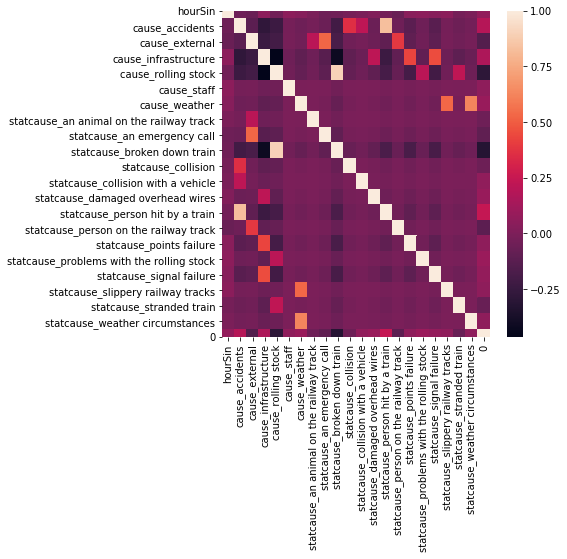

In [123]:
plt.figure(figsize=(6,6))
corr_matrix = pd.concat([X, pd.DataFrame(y)], axis=1).corr()
sea.heatmap(corr_matrix)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [125]:
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors
from sklearn import svm

#tree = tree.DecisionTreeClassifier(min_samples_leaf=80),
rf = ensemble.RandomForestClassifier(min_samples_leaf=20),

#svml = svm.LinearSVC(max_iter=1000, C=.01),
#svm = svm.SVC(max_iter=2000, C=1)

models = [
    ('tree', tree),
    ('rf', rf), 
    ('knn', knn) 
  #  ('svml', svml),
  #  ('svm', svm)
]

# predictions = []
# for model in models:
#     model.fit(X_train, y_train)
#     predictions.append(model.predict(X_train))

# predictions = pd.DataFrame(predictions).T

NameError: name 'knn' is not defined

In [126]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = tree.DecisionTreeClassifier(min_samples_leaf=80)
clf2 = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=80)
clf3 = neighbors.KNeighborsClassifier(25)
# clf4 = svm.LinearSVC(max_iter=2000, C=.01)
# clf5 = svm.SVC(max_iter=2000, C=1)

In [127]:
eclf1 = VotingClassifier(estimators=[('tree', clf1),
                                     ('rf', clf2), 
                                     ('knn', clf3)], voting='soft')

eclf1 = eclf1.fit(X_train, y_train)

In [128]:
np.mean(eclf1.predict(X_train) == y_train)

0.6953303355240401

In [129]:
np.mean(eclf1.predict(X_val) == y_val)

0.7061427780852241

In [130]:
np.mean(eclf1.predict(X_test) == y_test)

0.6888003541389995

In [131]:
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
# apply same transformation to test data
X_val = scaler.transform(X_val)  # doctest: +SKIP
X_test = scaler.transform(X_test)  # doctest: +SKIP

In [132]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=100,
                    learning_rate='adaptive',
                    hidden_layer_sizes=(5,),
                    max_iter=5000)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_val, y_val))

0.6857142857142857
0.7014388489208633


In [133]:
print(clf.score(X_test, y_test))

0.6899070385126163


In [134]:
import numpy as np